In [264]:
from scotus.db import DB
from scotus.settings import DEFAULT_DB
from scotus.learn import vote_predict

def justice_data(justice_id, data):
    '''split out the data for a single justice given the justice id'''
    d = data[data['justice_id']==justice_id]
    d = d[d['vote'] != 'none']
    return d

In [265]:
database = DB(DEFAULT_DB)
all_data = vote_predict.fetch_data(database)

In [266]:
kennedy_data = justice_data(9, all_data)

case_names = kennedy_data['name']

In [412]:
from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, StandardScaler

stats_columns = ['interrupted_petitioner', 'interrupted_respondent', 'interrupting_petitioner', 
                 'interrupting_respondent', 'number_turns_petitioner','number_turns_respondent',
                 'speaking_time_petitioner', 'speaking_time_respondent', 'turn_length_petitioner',
                 'turn_length_respondent', 'justice_interrupted_petitioner', 'justice_interrupted_respondent',
                 'justice_interrupting_petitioner', 'justice_interrupting_respondent', 
                 'justice_number_turns_petitioner', 'justice_number_turns_respondent', 
                 'justice_turn_length_petitioner', 'justice_turn_length_respondent']

statistics = DataFrameMapper([
                ('gender_petitioner', LabelEncoder()),
                ('gender_respondent', LabelEncoder()),
                (stats_columns, StandardScaler())])

class DocumentList(BaseEstimator, TransformerMixin):
    def __init__(self, column_id=None):
        self.column_id = column_id
    
    def fit(self, X, y=None):
        return self
  
    def transform(self, X, y=None):
        return X[self.column_id].tolist()
    
class DocumentPipeline(Pipeline):
    def __init__(self, column_id=None,
                 min_df=1, max_df=1.0, stop_words=None, sublinear_tf=False, 
                 ngram_range=(1,1), binary=False, use_idf=True,
                 topic= False, n_components=100):
        
        
        if topic:
            semantic = LatentDirichletAllocation(n_topics=n_components)
        else:
            semantic = TruncatedSVD(n_components=n_components)
    
        Pipeline.__init__(self, [('extract', DocumentList(column_id=column_id)),
                                 ('tfidf', TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words=stop_words,
                                                           ngram_range=ngram_range,
                                                          sublinear_tf=sublinear_tf, binary=binary, use_idf=use_idf)),
                                 ('semantic', semantic)])
        
    def make_topic_desc(self, topic_row):
        rank = np.argsort(topic_row)
        words = self.get_params()['tfidf'].get_feature_names()
        return ' | '.join(np.extract(rank>len(words)-11, words))
        
    
    def get_feature_names(self):
        coeffs = self.get_params()['semantic'].components_
        
        

features = FeatureUnion([
            ('facts', DocumentPipeline(column_id ='facts', 
                                       min_df=2, max_df=.8, stop_words='english', binary=True,
                                       sublinear_tf=False, ngram_range=(2,3), n_components=100, use_idf=True,
                                       topic=False)),
            ('argument_petitioner', DocumentPipeline(column_id='document_petitioner', min_df=2, max_df=.9, 
                                                     sublinear_tf=True, ngram_range=(1,2), n_components=100)),
            ('argument_respondent', DocumentPipeline(column_id='document_respondent', min_df=2, max_df=.9, 
                                                     sublinear_tf=True, ngram_range=(1,2), n_components=100)),
            ('justice_petitioner', DocumentPipeline(column_id='justice_document_petitioner', min_df=1, max_df=.95, 
                                                     sublinear_tf=True, ngram_range=(1,2), n_components=100)),
            ('justice_respondent', DocumentPipeline(column_id='justice_document_respondent', min_df=2, max_df=.9, 
                                                     sublinear_tf=True, ngram_range=(1,2), n_components=100)),
            ('statistics', statistics)])

labels = DataFrameMapper([('vote', LabelEncoder())])

In [413]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
y = labels.fit_transform(kennedy_data)
numeric_data = features.fit_transform(kennedy_data)
np.sum(y)

91

In [414]:
len(kennedy_data)

229

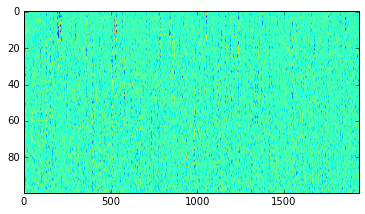

In [415]:
plt.imshow(features.get_params()['facts__semantic'].components_, aspect=10.5)
plt.show()

In [416]:
coeffs = features.get_params()['facts__semantic'].components_

In [425]:
rank = np.argsort(coeffs[0])

In [426]:
words = np.array(features.get_params()['facts__tfidf'].get_feature_names())

In [427]:
np.extract(rank>len(words)-6, words)

array([u'act statute', u'court supreme court', u'did investigate',
       u'management relations', u'rights violated'], 
      dtype='<U38')

In [424]:
np.argsort(features.get_params()['facts__semantic'].explained_variance_)

array([99, 98, 97, 96, 95, 94, 93, 92, 91,  0, 90, 89, 88, 87, 86, 85, 84,
       83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67,
       66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50,
       49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33,
       32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  2,  3,  1])